In [104]:
from dotenv import load_dotenv
import os
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
os.getcwd()

'C:\\Users\\HP\\Desktop\\rfm python'

In [105]:


load_dotenv()


True

In [106]:
DB_HOST = os.getenv("DB_HOST")
DB_NAME = os.getenv("DB_NAME")
DB_USER = os.getenv("DB_USER")
DB_PASSWORD = os.getenv("DB_PASSWORD")

In [107]:
DB_NAME

'postgres'

In [108]:
import psycopg2
import pandas as pd
from datetime import date
from psycopg2.extras import execute_values

In [109]:
conn = psycopg2.connect(
    host=os.getenv("DB_HOST"),
    database=os.getenv("DB_NAME"),
    user=os.getenv("DB_USER"),
    password=os.getenv("DB_PASSWORD"),
    port=os.getenv("DB_PORT")
)

cursor = conn.cursor()
run_date = date.today()

In [110]:
rfm_query = f"""
WITH base AS (
    SELECT
        customer_id,
        MAX(created_at) AS last_order_date,
        COUNT(order_id) AS frequency_orders,
        SUM(total) AS monetary_value
    FROM ecom.orders
    WHERE status != 'cancelled'
    GROUP BY customer_id
),

rfm AS (
    SELECT
        customer_id,
        DATE '{run_date}' AS run_date,
        DATE_PART('day', DATE '{run_date}' - last_order_date) AS recency_days,
        frequency_orders,
        monetary_value
    FROM base
),

scored AS (
    SELECT
        *,
        NTILE(5) OVER (ORDER BY recency_days DESC) AS r_score,
        NTILE(5) OVER (ORDER BY frequency_orders) AS f_score,
        NTILE(5) OVER (ORDER BY monetary_value) AS m_score
    FROM rfm
),

segmented AS (
    SELECT
        *,
        (r_score + f_score + m_score) AS rfm_score,
        CASE
        WHEN r_score >= 4 AND f_score >= 4 AND m_score >= 4 THEN 'Champions'
        WHEN f_score >= 4 AND m_score >= 4 AND r_score < 4 THEN 'Loyal High Spenders'
        WHEN f_score >= 4 AND m_score <= 3 THEN 'Loyal Budget Spenders'
        WHEN m_score >= 4 AND f_score <= 3 AND r_score >= 3 THEN 'Big Spenders'
        
        WHEN r_score = 5 AND f_score <= 2 AND m_score >= 4 THEN 'New High Value Customers'
        WHEN r_score = 5 AND f_score <= 2 AND m_score <= 2 THEN 'New Customers'
        WHEN r_score >= 4 AND f_score = 3 AND m_score = 3 THEN 'Potential Loyalists'
        WHEN r_score = 4 AND f_score = 2 AND m_score = 2 THEN 'Promising Customers'
        
        WHEN r_score <= 2 AND f_score >= 4 THEN 'Loyal At Risk'
        WHEN r_score <= 2 AND m_score >= 4 THEN 'Big Spenders At Risk'
        WHEN r_score = 2 AND f_score <= 2 AND m_score <= 2 THEN 'About to Churn'
        WHEN r_score = 1 AND f_score <= 2 AND m_score <= 2 THEN 'Hibernating'
        
        WHEN f_score = 1 AND m_score <= 2 THEN 'One-time Buyers'
        WHEN f_score >= 3 AND m_score = 1 THEN 'Bargain Hunters'
        WHEN r_score <= 3 AND f_score <= 2 AND m_score <= 2 THEN 'Low Value Customers'
        ELSE 'Others' 
        END AS comments
    FROM scored
)

SELECT
    run_date,
    customer_id,
    recency_days,
    frequency_orders,
    monetary_value,
    r_score,
    f_score,
    m_score,
    rfm_score,
    CASE
    WHEN rfm_score >=10  THEN 'Loyal Customers'
    WHEN rfm_score BETWEEN 8 AND 9 THEN 'Potential Loyalists'
    WHEN rfm_score BETWEEN 6 AND 7 THEN 'Promising Customers'
    WHEN rfm_score BETWEEN 4 AND 5 THEN 'At Risk'
    WHEN rfm_score = 3 THEN 'Hibernating'
    ELSE 'Others'
    END AS rfm_segment,
    comments
FROM segmented
order by customer_id;
"""


In [111]:
df = pd.read_sql(rfm_query, conn)


C:\Users\HP\AppData\Local\Temp\ipykernel_20888\2640835035.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(rfm_query, conn)


In [112]:
df

,run_date,customer_id,recency_days,frequency_orders,monetary_value,r_score,f_score,m_score,rfm_score,rfm_segment,comments
0,2026-01-29,1,52.0,4,20325.49,3,3,2,8,Potential Loyalists,Others
1,2026-01-29,2,41.0,3,9844.11,4,2,1,7,Promising Customers,Others
2,2026-01-29,3,94.0,2,20096.30,1,1,2,4,At Risk,Hibernating
3,2026-01-29,4,89.0,3,15886.69,1,3,2,6,Promising Customers,Others
4,2026-01-29,5,39.0,2,13250.04,4,1,1,6,Promising Customers,One-time Buyers
...,...,...,...,...,...,...,...,...,...,...,...
9784,2026-01-29,9995,45.0,3,33446.08,3,3,3,9,Potential Loyalists,Others
9785,2026-01-29,9996,93.0,3,35415.93,1,3,3,7,Promising Customers,Others
9786,2026-01-29,9997,46.0,7,35949.71,3,5,3,11,Loyal Customers,Loyal Budget Spenders
9787,2026-01-29,9999,85.0,1,6741.12,1,1,1,3,Hibernating,Hibernating


C:\Users\HP\Desktop\rfm python\venv\Lib\site-packages\seaborn\axisgrid.py:1550: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  func(x=data_k, label=label_k, color=color, **plot_kwargs)
C:\Users\HP\Desktop\rfm python\venv\Lib\site-packages\seaborn\axisgrid.py:1550: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  func(x=data_

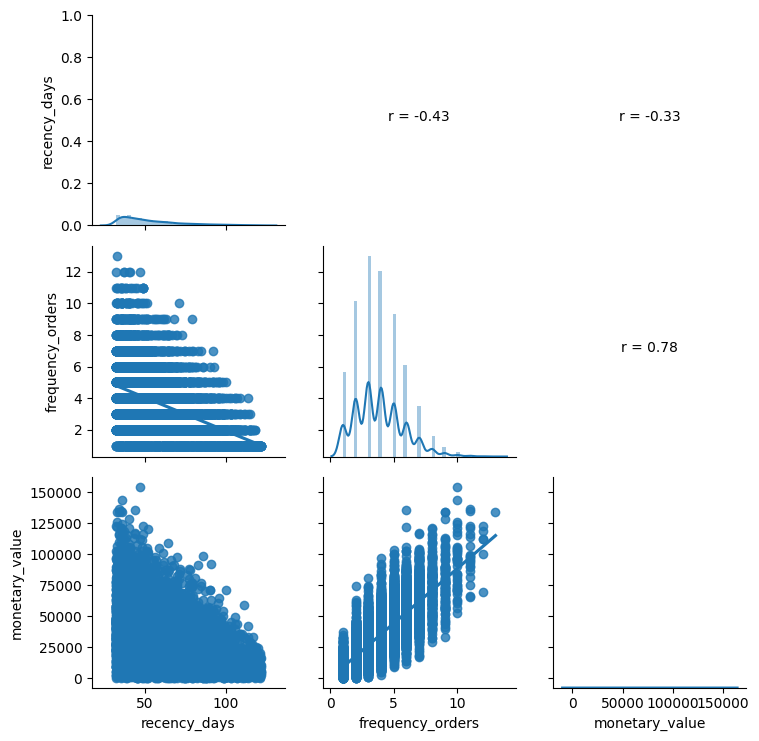

In [113]:
df1 = df[['recency_days','frequency_orders','monetary_value']].copy()

def reg_coef(x,y,label=None,color=None,**kwargs):
    ax = plt.gca()
    r,p = pearsonr(x,y)
    ax.annotate('r = {:.2f}'.format(r), xy=(0.5,0.5), xycoords='axes fraction', ha='center')
    ax.set_axis_off()

g = sns.PairGrid(df1)
g.map_diag(sns.distplot)
g.map_lower(sns.regplot)
g.map_upper(reg_coef)
plt.show()

In [114]:
df["created_at"] = pd.Timestamp.now()
df["updated_at"] = pd.Timestamp.now()
df["logs"] = '{"source":"daily_rfm_pipeline"}'

In [115]:
df

,run_date,customer_id,recency_days,frequency_orders,monetary_value,r_score,f_score,m_score,rfm_score,rfm_segment,comments,created_at,updated_at,logs
0,2026-01-29,1,52.0,4,20325.49,3,3,2,8,Potential Loyalists,Others,2026-01-29 14:48:31.744830,2026-01-29 14:48:31.744830,"{""source"":""daily_rfm_pipeline""}"
1,2026-01-29,2,41.0,3,9844.11,4,2,1,7,Promising Customers,Others,2026-01-29 14:48:31.744830,2026-01-29 14:48:31.744830,"{""source"":""daily_rfm_pipeline""}"
2,2026-01-29,3,94.0,2,20096.30,1,1,2,4,At Risk,Hibernating,2026-01-29 14:48:31.744830,2026-01-29 14:48:31.744830,"{""source"":""daily_rfm_pipeline""}"
3,2026-01-29,4,89.0,3,15886.69,1,3,2,6,Promising Customers,Others,2026-01-29 14:48:31.744830,2026-01-29 14:48:31.744830,"{""source"":""daily_rfm_pipeline""}"
4,2026-01-29,5,39.0,2,13250.04,4,1,1,6,Promising Customers,One-time Buyers,2026-01-29 14:48:31.744830,2026-01-29 14:48:31.744830,"{""source"":""daily_rfm_pipeline""}"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9784,2026-01-29,9995,45.0,3,33446.08,3,3,3,9,Potential Loyalists,Others,2026-01-29 14:48:31.744830,2026-01-29 14:48:31.744830,"{""source"":""daily_rfm_pipeline""}"
9785,2026-01-29,9996,93.0,3,35415.93,1,3,3,7,Promising Customers,Others,2026-01-29 14:48:31.744830,2026-01-29 14:48:31.744830,"{""source"":""daily_rfm_pipeline""}"
9786,2026-01-29,9997,46.0,7,35949.71,3,5,3,11,Loyal Customers,Loyal Budget Spenders,2026-01-29 14:48:31.744830,2026-01-29 14:48:31.744830,"{""source"":""daily_rfm_pipeline""}"
9787,2026-01-29,9999,85.0,1,6741.12,1,1,1,3,Hibernating,Hibernating,2026-01-29 14:48:31.744830,2026-01-29 14:48:31.744830,"{""source"":""daily_rfm_pipeline""}"


In [116]:
insert_query = """
INSERT INTO ecom.customer_rfm_daily (
    run_date, customer_id, recency_days, frequency_orders, monetary_value,
    r_score, f_score, m_score, rfm_score, rfm_segment, comments,
    created_at, updated_at, logs
)
VALUES %s
ON CONFLICT (run_date, customer_id)
DO UPDATE SET
    recency_days = EXCLUDED.recency_days,
    frequency_orders = EXCLUDED.frequency_orders,
    monetary_value = EXCLUDED.monetary_value,
    r_score = EXCLUDED.r_score,
    f_score = EXCLUDED.f_score,
    m_score = EXCLUDED.m_score,
    rfm_score = EXCLUDED.rfm_score,
    comments = EXCLUDED.comments,
    rfm_segment = EXCLUDED.rfm_segment,
    updated_at = CURRENT_TIMESTAMP,
    logs = EXCLUDED.logs;
"""

In [117]:
records = df.to_records(index=False).tolist()
execute_values(cursor, insert_query, records)
conn.commit()

In [118]:
print(f"Inserted/updated {len(df)} RFM records for {run_date}")

Inserted/updated 9789 RFM records for 2026-01-29


In [119]:
cursor.close()
conn.close()